# Computer Simulations - Project 2. @ ELTE
# Complete velocity Verlet algorithm for Molecular Dynamics simulation in an enclosed box

In [1]:
import os
import sys
import random
import numpy as np
from numba import jit
from scipy import stats
from datetime import datetime

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d

from IPython.display import display, clear_output

In [2]:
figsave_dir = '..\\Documentation\\Report\\src\\img_src\\'
figsave_format = 'pdf'
figsave_dpi = 200

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

## Prefixing parameters and constants

In [3]:
def initial_parameters():
    # Number of particles
    N = 64
    # Number of pairs
    n_pairs = int(N * (N - 1) / 2)
    # Tempreature
    T = 50
    # Side length of box
    L = None
    # Mean density of particles
    rho = 1.2
    # Time step length
    dt = 1e-3

    # Cut-off limit of Lennard-Jones Potential
    r_c = 2.5
    # Maximal size of pair-list
    r_max = 3.2
    # Update interval of updating the pair-list
    update_interval = 10

    # In the short description it is discussed, that
    # it is adviced to choose some physical quantities to 1
    # as it makes the calculations easier.
    m = 1
    V_0 = 1
    sigma = 1

    # Boundary conditions for the simulation
    # boundary = ['periodic' | 'bounded']
    boundary = 'periodic'

    # Natural constants
    # However calculating velocities, we set k_B to 1
    k_B = 1.38e-23    # Boltzmann constant [J/K]
    N_A = 6.022e23    # Avogadro's number [1/mol]
    
    return N, n_pairs, T, L, rho, dt, r_c, r_max, update_interval,\
           m, V_0, sigma, boundary, k_B, N_A

### Auxiliary functions

In [4]:
@jit(nopython=True)
def sign_choose():
    return -1 if np.random.random() > 0.5 else 1

In [5]:
@jit(nopython=True)
def instantaneous_temperature(v):
    vSqd = 0
    for i in range(N):
        for k in range(3):
            vSqd += v[i][k]**2
    return vSqd / (3 * (N - 1))

In [6]:
@jit(nopython=True)
def instantaneous_kinetic_E(v):
    vSqd = 0
    for i in range(N):
        for k in range(3):
            vSqd += v[i][k]**2
    
    return 1/2 * m * vSqd    

### Calculate the initial condition

In [7]:
@jit(nopython=True)
def init_lattice_params(N, L, rho):
    
    if L is None and rho is None:
        raise AttributeError('Either \'rho\' or \'L\' should be given!')
    # Compute side of cube (L) from number of particles (N) and number density (rho)
    if L is None and rho is not None:
        L = (N / rho)**(1/3)
    # If L is given always use its value instead of rho
    elif L is not None and rho is None:
        rho = N / L**3
    else:
        rho = N / L**3

    # Find M large enough to fit N atoms on an fcc lattice
    M = 1
    while 4 * M**3 < N:
        M += 1

    # Lattice constant of conventional cell
    a_latt = L / M
    
    return L, rho, M, a_latt

### Updating pair-list

In [8]:
@jit(nopython=True)
def compute_separation(r, i, j):
    # Find separation using closest image convention
    dr_sqd = 0
    dr = np.zeros((3))
    for k in range(3):
        dr[k] = r[i][k] - r[j][k]
        if boundary == 'periodic':
            # Closest image convention
            if dr[k] >= 0.5*L:
                dr[k] -= L
            if dr[k] < -0.5*L:
                dr[k] += L
        dr_sqd += dr[k]**2
    return dr, dr_sqd

In [9]:
@jit(nopython=True)
def update_pair_list(r):

    #print('Pre-update n_pairs :', n_pairs)
    pair_list = []

    # Start counting number of pairs from 0 again
    n_pairs = 0
    for i in range(N-1):
        for j in range(i+1, N):
            dr, dr_sqd = compute_separation(r, i, j)
            if dr_sqd < r_max**2:
                pair_list.append([i, j])
                n_pairs += 1
    pair_list = np.array(pair_list)
    #print('After-update n_pairs :', n_pairs)
    return pair_list, n_pairs

In [10]:
@jit(nopython=True)
def update_pair_separations(r, pair_list):
    
    #print('Separation-in n_pairs :', n_pairs)
    #print('Separation-in len(pair_list) :', len(pair_list))
    dr_pair = np.zeros((n_pairs,3))
    dr_sqd_pair = np.zeros(n_pairs)

    for p in range(n_pairs):
        i = pair_list[p][0]
        j = pair_list[p][1]
        dr, dr_sqd = compute_separation(r, i, j)
        dr_pair[p] = dr
        dr_sqd_pair[p] = dr_sqd
        
    return dr_pair, dr_sqd_pair

### Calculating $\vec{r}$, $\vec{v}$ and $\vec{a}$ with corrections

In [11]:
@jit(nopython=True)
def init_positions():
    
    r = np.zeros((N,3))

    # 4 atomic positions in fcc unit cell 
    xCell = np.array((0.25, 0.75, 0.75, 0.25))
    yCell = np.array((0.25, 0.75, 0.25, 0.75))
    zCell = np.array((0.25, 0.25, 0.75, 0.75))

    # Atoms placed so far
    n = 0
    for x in range(M):
        for y in range(M):
            for z in range(M):
                for k in range(4):
                    if (n < N):
                        r[n][0] = (x + xCell[k]) * a_latt
                        r[n][1] = (y + yCell[k]) * a_latt
                        r[n][2] = (z + zCell[k]) * a_latt
                        n += 1
    return r

In [12]:
@jit(nopython=True)
def gasdev():
    available = False
    if available is False:
        while True:
            # Pick two uniform numbers in the square extending from -1 to +1 in each direction
            v1 = np.random.random() * sign_choose()
            v2 = np.random.random() * sign_choose()
            # See if they are inside the unit circle
            rsq = v1**2 + v2**2
            # If they are not, try again
            if rsq >= 1 or rsq == 0:
                continue
            else:
                break
        # Now make the Box-Müller transformation to get two normal deviates.
        # Return one and save the other for next time.
        fac = np.sqrt(-2 * np.log(rsq) / rsq)
        gset = v1 * fac
        available = True
        return v2 * fac
    else:
        available = False
        return gset

In [13]:
@jit(nopython=True)
def rescale_velocities(v):
    v_sqd_sum = 0
    for n in range(N):
        v_sqd_sum += np.sum(v[n]**2)
    lmbda = np.sqrt(3 * (N-1) * T / v_sqd_sum)
    v *= lmbda

    return v

In [14]:
@jit(nopython=True)
def init_velocities(mode='numpy'):
    
    v = np.zeros((N,3))
    
    # Gaussian with unit variance
    if mode=='numpy':
        for n in range(N):
            for i in range(3):
                v[n][i] = np.random.normal()
    else:
        for n in range(N):
            for i in range(3):
                v[n][i] = gasdev()
    
    # Calculate velocity of CM
    # v_CM = sum_i v_i / N
    v_CM = np.zeros(3)
    for n in range(N):
        v_CM += v[n]
    v_CM /= N

    # Substract from velocities
    for n in range(N):
        v[n] -= v_CM

    # Rescale velocities to get the desired instantaneous temperature
    v = rescale_velocities(v)
    
    return v

In [15]:
@jit(nopython=True)
def compute_accelerations(pair_list, dr_pair, dr_sqd_pair):
    
    # Potential energy
    potential_E = 0
    
    # Virial theorem
    virial_E = 0

    # All accelerations at the start of the step are set to 0
    a = np.zeros((N,3))

    for p in range(n_pairs):
        i = int(pair_list[p][0])
        j = int(pair_list[p][1])
        if dr_sqd_pair[p] < r_c**2:
            # rx_inv = 1/r^x
            r2_inv = 1 / dr_sqd_pair[p]
            r6_inv = r2_inv**3
            r12_inv = r6_inv**2
            # Force between the particles with indeces 'i' and 'j'
            # F = 24 * V_0 * r2_inv * (2 * sigma^12 * r12_inv - sigma^6 * r6_inv) * |r|
            F_wo_r = 24 * V_0 * r2_inv * (2 * sigma**12 * r12_inv - sigma**6 * r6_inv)

            # Calculate accelerations of interacting particles
            # a = F/m
            # Since m = 1, we can write a = F
            for d in range(3):
                F = F_wo_r * dr_pair[p][d]
                a[i][d] += F
                a[j][d] -= F
                
                if i < j:
                    virial_E += r[i][d] * F

            # Step with potential energy
            # V = 4 * V_0 * (sigma^12 * r12_inv - sigma^6 * r6_inv)
            potential_E += 4 * V_0 * (sigma**12 * r12_inv - sigma**6 * r6_inv)
            
            

    return a, potential_E, virial_E

### Velocity Verlet integration

In [16]:
@jit(nopython=True)
def velocity_verlet(r, v, a, pair_list, dr_pair, dr_sqd_pair):

    # Verlet stepping rule for coordinates:
    # r_(n+1) = r_(n) + dt * v_(n) + 1/2 * dt^2 * a_(n)
    for i in range(N):
        for k in range(3):
            r[i][k] += dt * v[i][k] + 0.5 * dt**2 * a[i][k]

            if(boundary == 'periodic'):
                # Use periodic boundary conditions
                if (r[i][k] < 0):
                    r[i][k] += L
                if (r[i][k] >= L):
                    r[i][k] -= L

            # Verlet stepping rule for velocity
            # v_(n+1) = v_(n) + 1/2 * dt * a_(n+1) + {{1/2 * dt * a_(n)}}
            # First step with the {{a_(n)}} part
            v[i][k] += 0.5 * dt * a[i][k]

    # Calculate a_(n+1)
    dr_pair, dr_sqd_pair = update_pair_separations(r, pair_list)
    a, potential_E, virial_E = compute_accelerations(pair_list, dr_pair, dr_sqd_pair)

    for i in range(N):
        for k in range(3):
            if(boundary == 'bounded'):
                # use bounded boundary conditions
                if (r[i][k] < 0 or r[i][k] >= L):
                    v[i][k] *= -1
                    a[i][k] *= -1

            # Verlet stepping rule for velocity
            # v_(n+1) = v_(n) + {{1/2 * dt * a_(n+1)}} + 1/2 * dt * a_(n)
            # Now add the {{a_(n+1)}} part
            v[i][k] += 0.5 * dt * a[i][k]

    kinetic_E = instantaneous_kinetic_E(v)

    return r, v, a, pair_list, dr_pair, dr_sqd_pair, kinetic_E, potential_E, virial_E

### Run the simulation

In [17]:
# Number of simulated steps
n_steps = 2000

In [18]:
# Initial parameters
N, n_pairs, T, L, rho, dt, r_c, r_max, update_interval,\
                     m, V_0, sigma, boundary, k_B, N_A = initial_parameters()
L, rho, M, a_latt = init_lattice_params(N, L, rho)

# ---------- HISTORICAL PARAMETERS ----------
r_history = np.zeros((n_steps+1, N, 3))
v_history = np.zeros((n_steps+1, N, 3))
a_history = np.zeros((n_steps+1, N, 3))
kinetic_E_history = np.zeros(n_steps+1)
potential_E_history = np.zeros(n_steps+1)
virial_E_history = np.zeros(n_steps+1)
temperature_history = np.zeros(n_steps+1)

# ---------- INITIALIZATION ----------
# Starting values
r = init_positions()
v = init_velocities()

pair_list, n_pairs = update_pair_list(r)
dr_pair, dr_sqd_pair = update_pair_separations(r, pair_list)

a, potential_E, virial_E = compute_accelerations(pair_list, dr_pair, dr_sqd_pair)

r_history[0] = r
v_history[0] = v
a_history[0] = a
kinetic_E_history[0] = instantaneous_kinetic_E(v)
potential_E_history[0] = potential_E
virial_E_history[0] = virial_E
temperature_history[0] = instantaneous_temperature(v)


# ---------- STEPPING THE SIMULATION ----------
for i in range(n_steps):
    #print(n_pairs)
    r, v, a, pair_list, dr_pair, dr_sqd_pair, kinetic_E, potential_E, virial_E =\
    velocity_verlet(r, v, a, pair_list, dr_pair, dr_sqd_pair)
    if i % 200 == 0:
        v = rescale_velocities(v)
        clear_output(wait=True)
        print('Current run: {0}/{1}'.format(i, n_steps))

    if i % update_interval == 0:
        #print('Pre-interval n_pairs :', n_pairs)
        #print('Pre-interval len(pair_list) :', len(pair_list))
        pair_list, n_pairs = update_pair_list(r)
        #print(n_pairs)
        #print('After-interval n_pairs :', n_pairs)
        #print('After-interval len(pair_list) :', len(pair_list))
        dr_pair, dr_sqd_pair = update_pair_separations(r, pair_list)

    r_history[i+1] = r
    v_history[i+1] = v
    a_history[i+1] = a
    kinetic_E_history[i+1] = kinetic_E
    potential_E_history[i+1] = potential_E
    virial_E_history[i+1] = virial_E
    temperature_history[i+1] = instantaneous_temperature(v)

clear_output()
print('Finished!')

Finished!


## Plot data

### Instantaneous energy

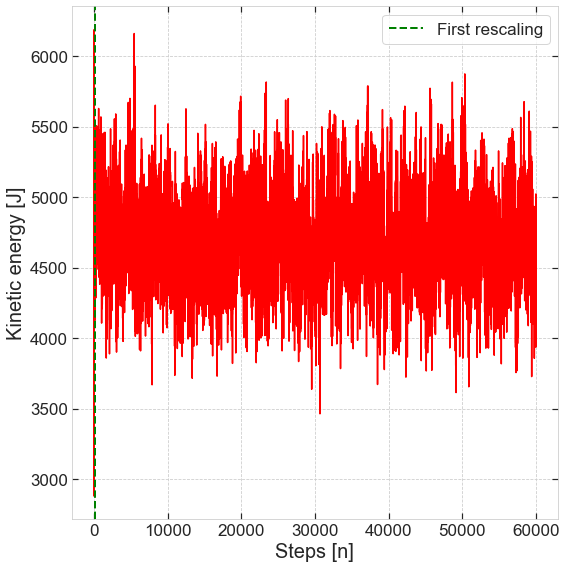

In [19]:
save = True
nrows=1
ncols=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8,nrows*8))

titlesize = 23
axislabelsize = 20

axes.plot(np.arange(n_steps+1), kinetic_E_history, color='red')

axes.axvline(x=200, lw=2, ls='--',  color='green', label='First rescaling')
#axes.axvline(x=equlibrium, linewidth=2, linestyle='--',  color='black', label='Equilibrium')
axes.set_xlabel('Steps [n]', fontsize=axislabelsize)
axes.set_ylabel('Kinetic energy [J]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axislabelsize-3)
axes.yaxis.get_offset_text().set_size(15)
axes.legend(loc='upper right', fontsize=17)

fig.tight_layout()
if save:
    plt.savefig(figsave_dir +
                'instantaneous_kinetic_E_{0}.'.format(n_steps) +
                figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

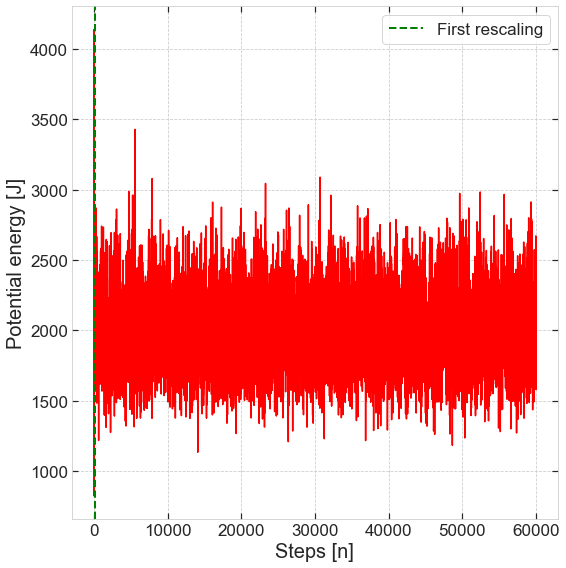

In [20]:
save = True
nrows=1
ncols=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8,nrows*8))

titlesize = 23
axislabelsize = 20

axes.plot(np.arange(n_steps+1), potential_E_history, color='red')

axes.axvline(x=200, lw=2, ls='--',  color='green', label='First rescaling')
#axes.axvline(x=equlibrium, linewidth=2, linestyle='--',  color='black', label='Equilibrium')
axes.set_xlabel('Steps [n]', fontsize=axislabelsize)
axes.set_ylabel('Potential energy [J]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axislabelsize-3)
axes.yaxis.get_offset_text().set_size(15)
axes.legend(loc='upper right', fontsize=17)

fig.tight_layout()
if save:
    plt.savefig(figsave_dir +
                'instantaneous_potential_E_{0}.'.format(n_steps) +
                figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

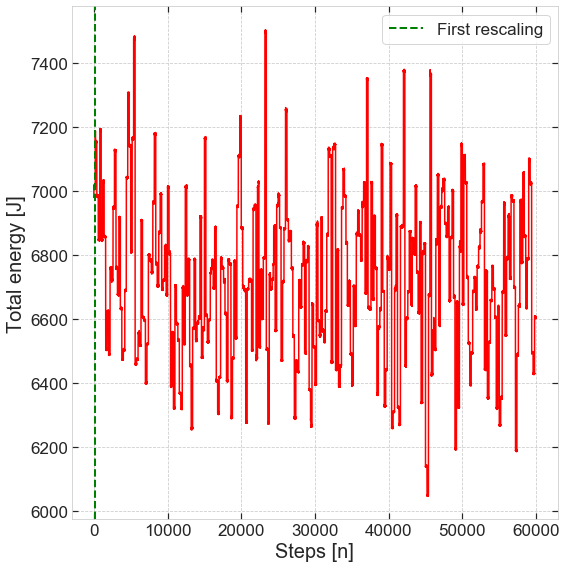

In [21]:
save = True
nrows=1
ncols=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8,nrows*8))

titlesize = 23
axislabelsize = 20

axes.plot(np.arange(n_steps+1), kinetic_E_history+potential_E_history, color='red')

axes.axvline(x=200, lw=2, ls='--',  color='green', label='First rescaling')
#axes.axvline(x=equlibrium, linewidth=2, linestyle='--',  color='black', label='Equilibrium')
axes.set_xlabel('Steps [n]', fontsize=axislabelsize)
axes.set_ylabel('Total energy [J]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axislabelsize-3)
axes.yaxis.get_offset_text().set_size(15)
axes.legend(loc='upper right', fontsize=17)

fig.tight_layout()
if save:
    plt.savefig(figsave_dir +
                'instantaneous_total_E_{0}.'.format(n_steps) +
                figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

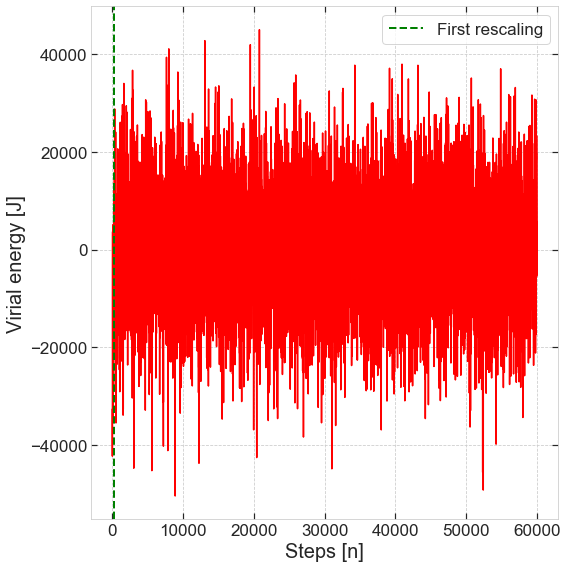

In [22]:
save = True
nrows=1
ncols=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8,nrows*8))

titlesize = 23
axislabelsize = 20

axes.plot(np.arange(n_steps+1), virial_E_history, color='red')

axes.axvline(x=200, lw=2, ls='--',  color='green', label='First rescaling')
#axes.axvline(x=equlibrium, linewidth=2, linestyle='--',  color='black', label='Equilibrium')
axes.set_xlabel('Steps [n]', fontsize=axislabelsize)
axes.set_ylabel('Virial energy [J]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axislabelsize-3)
axes.yaxis.get_offset_text().set_size(15)
axes.legend(loc='upper right', fontsize=17)

fig.tight_layout()
if save:
    plt.savefig(figsave_dir +
                'instantaneous_virial_E_{0}.'.format(n_steps) +
                figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

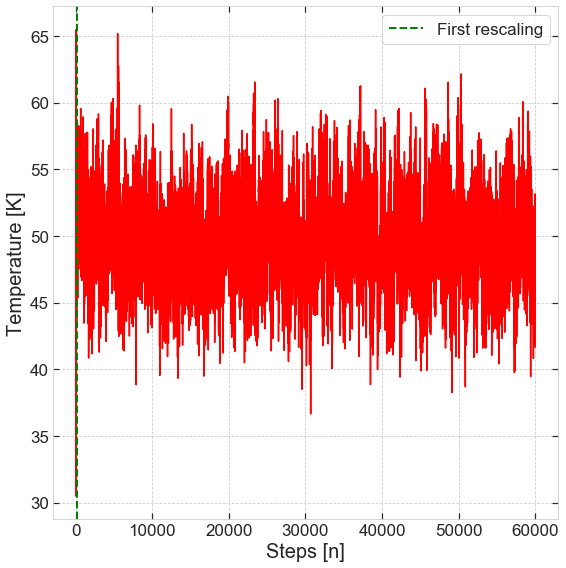

In [23]:
save = True
nrows=1
ncols=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8,nrows*8))

titlesize = 23
axislabelsize = 20

axes.plot(np.arange(n_steps+1), temperature_history, color='red')

axes.axvline(x=200, lw=2, ls='--',  color='green', label='First rescaling')
#axes.axvline(x=equlibrium, linewidth=2, linestyle='--',  color='black', label='Equilibrium')
axes.set_xlabel('Steps [n]', fontsize=axislabelsize)
axes.set_ylabel('Temperature [K]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axislabelsize-3)
axes.yaxis.get_offset_text().set_size(15)
axes.legend(loc='upper right', fontsize=17)

fig.tight_layout()
if save:
    plt.savefig(figsave_dir +
                'instantaneous_temperatures_{0}.'.format(n_steps) +
                figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

## Calculations for $<E>$, $<E^2>$, $C_V$, $Z$

In [90]:
equilibrium = 200
X = np.arange(equilibrium, n_steps)
virial_E_prop = np.array([np.mean(virial_E_history[equilibrium:i+1]) for i in range(equilibrium, n_steps)])
T_prop = np.array([np.mean(temperature_history[equilibrium:i+1]) for i in range(equilibrium, n_steps)])

In [25]:
E_tot_equi = kinetic_E_history[equilibrium:] + potential_E_history[equilibrium:]
E_exp = np.mean(E_tot_equi)
E_exp_sqd = E_exp**2
E_sqd_exp = np.mean(E_tot_equi**2)

E_var = E_sqd_exp - E_exp_sqd
E_dist = np.sqrt(E_var)

print('Expected value of total energy : {0} J'.format(E_exp))
print('Square of expected value of total energy : {0} J^2'.format(E_exp_sqd))
print('Expected value of squared total energy : {0} J^2'.format(E_sqd_exp))
print('Variance of total energy : {0} J^2'.format(E_var))
print('Standard deviation of total energy : {0} J'.format(E_dist))

Expected value of total energy : 6721.738134968661 J
Square of expected value of total energy : 45181763.55509198 J^2
Expected value of squared total energy : 45246124.65607192 J^2
Variance of total energy : 64361.100979946554 J^2
Standard deviation of total energy : 253.69489742591702 J


## Propagation of means

In [26]:
E_exp_prop = [np.mean(E_tot_equi[:i+1]) for i in range(n_steps - equilibrium)]

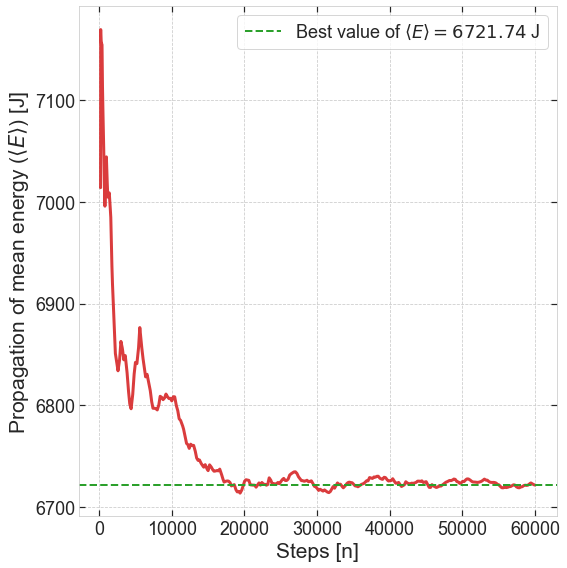

In [27]:
save = True

nrows=1
ncols=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8,nrows*8))

titlesize = 23
axislabelsize = 21
axisticksize = 18
legendsize = 18

axes.set_xlabel('Steps [n]', fontsize=axislabelsize)
axes.set_ylabel('Propagation of mean energy ($\\left< E \\right>$) [J]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)
axes.yaxis.get_offset_text().set_size(15)

axes.plot(X, E_exp_prop,
          color='tab:red', lw=3, alpha=0.9)
axes.axhline(y=E_exp_prop[-1],
             lw=2, ls='--', color='tab:green',
             label='Best value of $\\left< E \\right> = {0:.2f}$ J'.format(E_exp_prop[-1]))

axes.legend(loc='upper right', fontsize=legendsize)

fig.tight_layout()
if save:
    plt.savefig(figsave_dir +
                'energy_propagation_{0}.'.format(n_steps) +
                figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

In [28]:
E_exp_sqd_prop = [np.mean(np.square(E_tot_equi[:i+1])) for i in range(n_steps - equilibrium)]

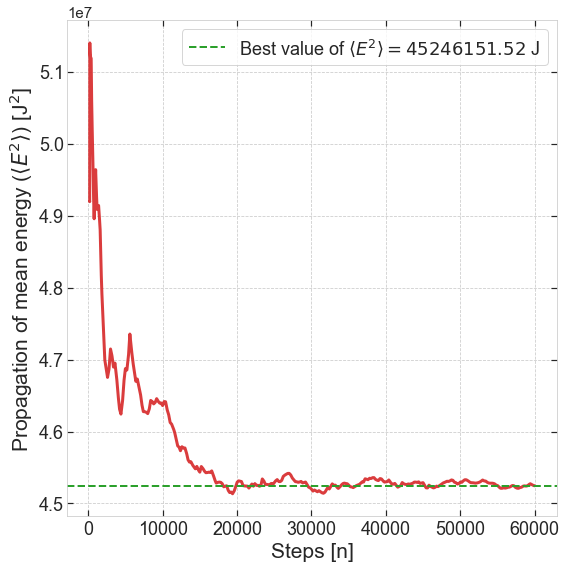

In [29]:
save = True

nrows=1
ncols=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8,nrows*8))

titlesize = 23
axislabelsize = 21
axisticksize = 18
legendsize = 18

axes.set_xlabel('Steps [n]', fontsize=axislabelsize)
axes.set_ylabel('Propagation of mean energy ($\\left< E^2 \\right>$) [J$^2$]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)
axes.yaxis.get_offset_text().set_size(15)

axes.plot(X, E_exp_sqd_prop,
          color='tab:red', lw=3, alpha=0.9)
axes.axhline(y=E_exp_sqd_prop[-1],
             lw=2, ls='--', color='tab:green',
             label='Best value of $\\left< E^2 \\right> = {0:.2f}$ J'.format(E_exp_sqd_prop[-1]))

axes.legend(loc='upper right', fontsize=legendsize)

fig.tight_layout()
if save:
    plt.savefig(figsave_dir +
                'energy_squared_propagation_{0}.'.format(n_steps) +
                figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

In [60]:
E_var_prop = E_exp_sqd_prop - np.square(E_exp_prop)

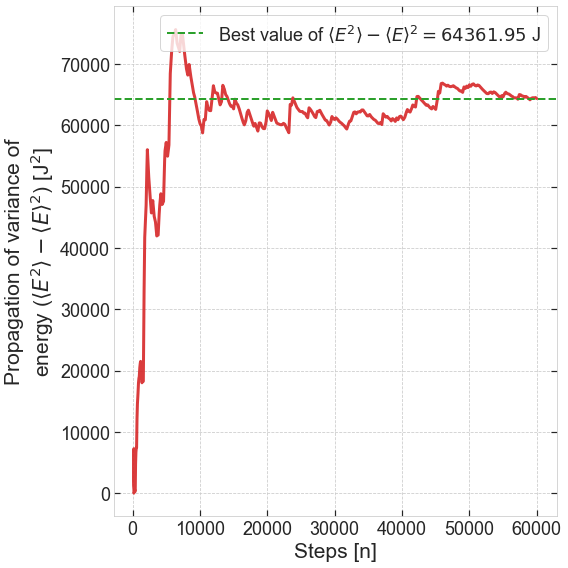

In [61]:
save = True

nrows=1
ncols=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8,nrows*8))

titlesize = 23
axislabelsize = 21
axisticksize = 18
legendsize = 18

axes.set_xlabel('Steps [n]', fontsize=axislabelsize)
axes.set_ylabel('Propagation of variance of\nenergy ($\\left< E^2 \\right> - \\left< E \\right>^2$) [J$^2$]',
                fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)
axes.yaxis.get_offset_text().set_size(15)

axes.plot(X, E_var_prop,
          color='tab:red', lw=3, alpha=0.9)
axes.axhline(y=E_dist_prop[-1],
             lw=2, ls='--', color='tab:green',
             label='Best value of $\\left< E^2 \\right> - \\left< E \\right>^2 = {0:.2f}$ J'.format(E_dist_prop[-1]))

axes.legend(loc='upper right', fontsize=legendsize)

fig.tight_layout()
if save:
    plt.savefig(figsave_dir +
                'energy_variance_propagation_{0}.'.format(n_steps) +
                figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

## Heat capacity

Dimension:

$$
[C_{V}]
=
\left[ \frac{1}{k_{B} T^{2}} \cdot \left( \left< E^{2} \right> - \left< E \right>^{2} \right) \right]
=
\frac{1}{\frac{J}{K} \cdot K^{2}} \cdot J^{2}
=
\frac{J}{K}
$$

For argon gas it's

$$
12.76\ \frac{J}{mol \cdot K}
$$

In [112]:
# Since k_B = N_A = 1 in the simulation
C_V = E_var * (1/(np.mean(temperature_history[equilibrium+1:])**2))
C_V_prop = E_dist_prop * 1/temperature_history[equilibrium+1:]**2
C_V_mean_prop = E_dist_prop * 1/T_prop**2

print('Molar heat capacity of the simulated gas : {0} J mol^-1 K^-1'.format(C_V))

Molar heat capacity of the simulated gas : 25.794855765238772 J mol^-1 K^-1


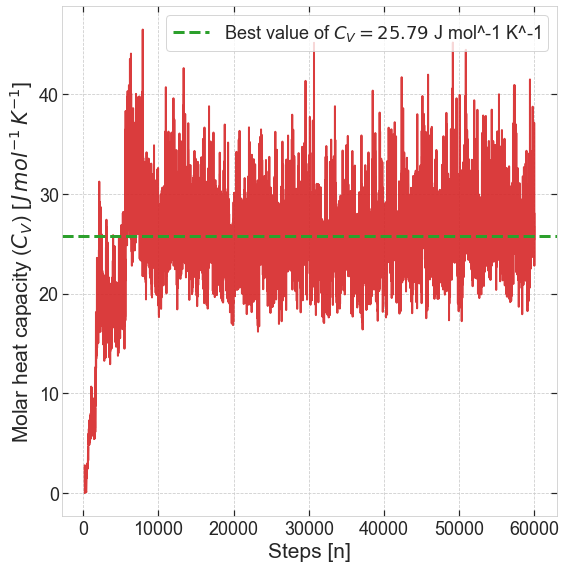

In [113]:
save = True

nrows=1
ncols=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8,nrows*8))

titlesize = 23
axislabelsize = 21
axisticksize = 18
legendsize = 18

axes.set_xlabel('Steps [n]', fontsize=axislabelsize)
axes.set_ylabel('Molar heat capacity ($C_{V}$) [$\,J\, mol^{-1}\, K^{-1}$]',
                fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)
axes.yaxis.get_offset_text().set_size(15)

axes.plot(X, C_V_prop,
          color='tab:red', lw=2, alpha=0.9)
axes.axhline(y=C_V,
             lw=3, ls='--', color='tab:green',
             label='Best value of $C_V = {0:.2f}$ J mol^-1 K^-1'.format(C_V))

axes.legend(loc='upper right', fontsize=legendsize)

fig.tight_layout()
if save:
    plt.savefig(figsave_dir +
                'C_V_propagation_{0}.'.format(n_steps) +
                figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

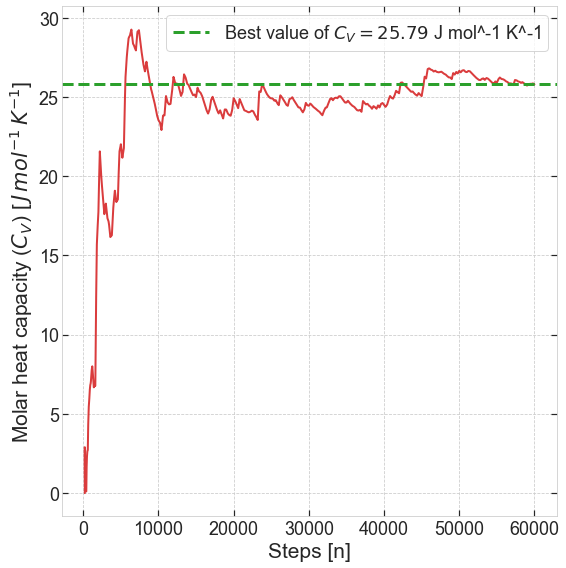

In [114]:
save = True

nrows=1
ncols=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8,nrows*8))

titlesize = 23
axislabelsize = 21
axisticksize = 18
legendsize = 18

axes.set_xlabel('Steps [n]', fontsize=axislabelsize)
axes.set_ylabel('Molar heat capacity ($C_{V}$) [$\,J\, mol^{-1}\, K^{-1}$]',
                fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)
axes.yaxis.get_offset_text().set_size(15)

axes.plot(X, C_V_mean_prop,
          color='tab:red', lw=2, alpha=0.9)
axes.axhline(y=C_V,
             lw=3, ls='--', color='tab:green',
             label='Best value of $C_V = {0:.2f}$ J mol^-1 K^-1'.format(C_V))

axes.legend(loc='upper right', fontsize=legendsize)

fig.tight_layout()
if save:
    plt.savefig(figsave_dir +
                'C_V_mean_propagation_{0}.'.format(n_steps) +
                figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

## Pressure

In [99]:
pV_exp = np.mean(virial_E_history[equilibrium+1:])
T_mean = np.mean(temperature_history[equilibrium+1:])

pV = N * T_mean + 1/3 * pV_exp
p = pV / L**3
p_ideal = N * T_mean / L**3

pV_prop = N * temperature_history[equilibrium+1:] + 1/3 * virial_E_prop
p_prop = pV_prop / L**3

pV_mean_prop = N * T_prop + 1/3 * virial_E_prop
p_mean_prop = pV_mean_prop / L**3

print('Pressure of the system is {0:.3f} Pa'.format(p))
print('Should be according to the ideal gas law approximately : {0:.3f} Pa'.format(p_ideal))

Pressure of the system is 59.592 Pa
Should be according to the ideal gas law approximately : 59.941 Pa


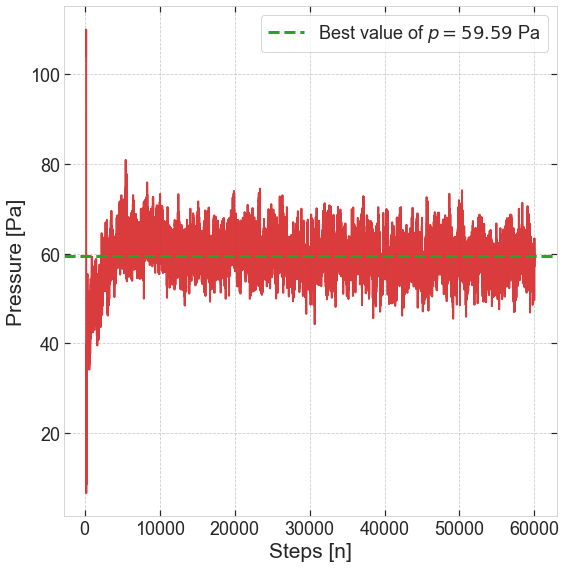

In [101]:
save = True

nrows=1
ncols=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8,nrows*8))

titlesize = 23
axislabelsize = 21
axisticksize = 18
legendsize = 18

axes.set_xlabel('Steps [n]', fontsize=axislabelsize)
axes.set_ylabel('Pressure [Pa]',
                fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)
axes.yaxis.get_offset_text().set_size(15)

axes.plot(X, p_prop,
          color='tab:red', lw=2, alpha=0.9)
axes.axhline(y=p,
             lw=3, ls='--', color='tab:green',
             label='Best value of $p = {0:.2f}$ Pa'.format(p))

axes.legend(loc='upper right', fontsize=legendsize)

fig.tight_layout()
if save:
    plt.savefig(figsave_dir +
                'p_propagation_{0}.'.format(n_steps) +
                figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

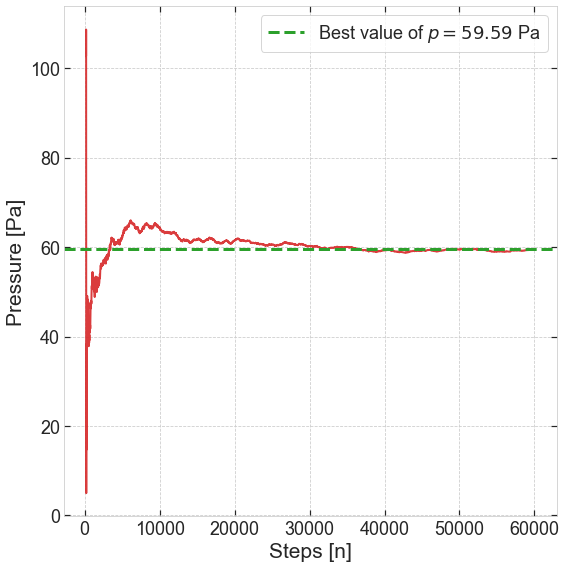

In [100]:
save = True

nrows=1
ncols=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8,nrows*8))

titlesize = 23
axislabelsize = 21
axisticksize = 18
legendsize = 18

axes.set_xlabel('Steps [n]', fontsize=axislabelsize)
axes.set_ylabel('Pressure [Pa]',
                fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)
axes.yaxis.get_offset_text().set_size(15)

axes.plot(X, p_mean_prop,
          color='tab:red', lw=2, alpha=0.9)
axes.axhline(y=p,
             lw=3, ls='--', color='tab:green',
             label='Best value of $p = {0:.2f}$ Pa'.format(p))

axes.legend(loc='upper right', fontsize=legendsize)

fig.tight_layout()
if save:
    plt.savefig(figsave_dir +
                'p_mean_propagation_{0}.'.format(n_steps) +
                figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

## Compressibility factor

Dimension:

$$
[Z]
=
\left[ \frac{pV}{N k_{B} T} \right]
=
\frac{\frac{\text{kg}}{\text{m}\ \text{s}^{2}} \text{m}^{3}}{1 \frac{\text{J}}{\text{K}} \text{K}}
=
\frac{\frac{\text{kg}}{\text{m}\ \text{s}^{2}} \text{m}^{3}}{\frac{\text{kg}\ \text{m}^{2}}{\text{s}^{2}}}
=
\frac{\text{m}^{2}}{\text{m}^{2}}
=
1
$$

In [115]:
Z = pV / (N * T_mean)

Z_prop = pV_prop / (N * temperature_history[equilibrium+1:])
Z_mean_prop = pV_mean_prop / (N * T_prop)

print('Compressibility factor of the simulated system : {0:.5f}'.format(Z))
print('Should be approximately from measurements : {0:.5f}'.format(p/p_ideal))

Compressibility factor of the simulated system : 0.99418
Should be approximately from measurements : 0.99418


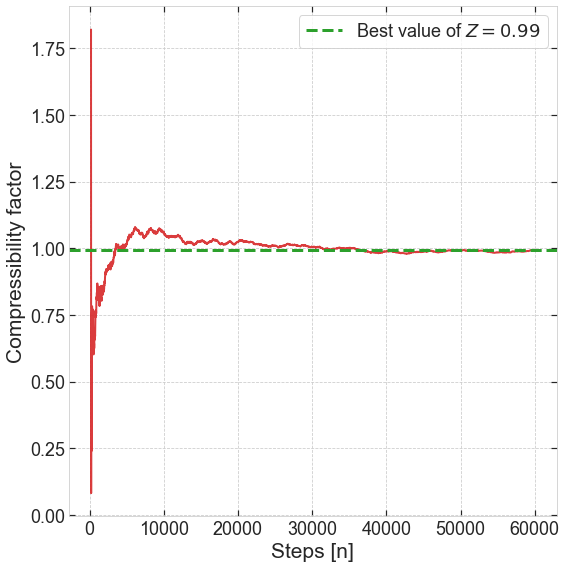

In [116]:
save = True

nrows=1
ncols=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8,nrows*8))

titlesize = 23
axislabelsize = 21
axisticksize = 18
legendsize = 18

axes.set_xlabel('Steps [n]', fontsize=axislabelsize)
axes.set_ylabel('Compressibility factor',
                fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)
axes.yaxis.get_offset_text().set_size(15)

axes.plot(X, Z_mean_prop,
          color='tab:red', lw=2, alpha=0.9)
axes.axhline(y=Z,
             lw=3, ls='--', color='tab:green',
             label='Best value of $Z = {0:.2f}$'.format(Z))

axes.legend(loc='upper right', fontsize=legendsize)

fig.tight_layout()
if save:
    plt.savefig(figsave_dir +
                'Z_mean_propagation_{0}.'.format(n_steps) +
                figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

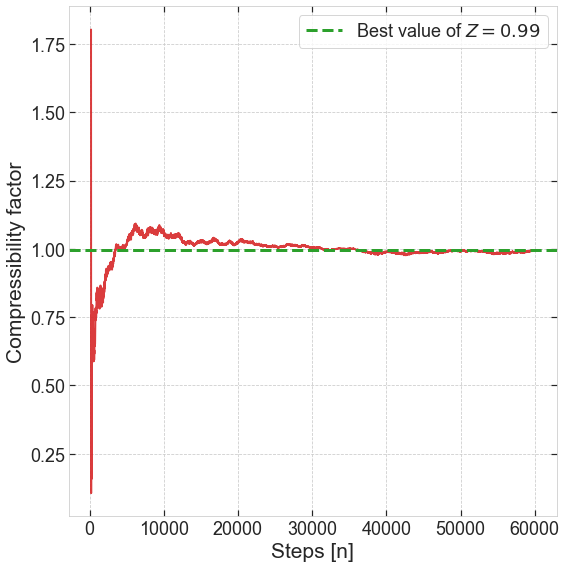

In [117]:
save = True

nrows=1
ncols=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8,nrows*8))

titlesize = 23
axislabelsize = 21
axisticksize = 18
legendsize = 18

axes.set_xlabel('Steps [n]', fontsize=axislabelsize)
axes.set_ylabel('Compressibility factor',
                fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)
axes.yaxis.get_offset_text().set_size(15)

axes.plot(X, Z_prop,
          color='tab:red', lw=2, alpha=0.9)
axes.axhline(y=Z,
             lw=3, ls='--', color='tab:green',
             label='Best value of $Z = {0:.2f}$'.format(Z))

axes.legend(loc='upper right', fontsize=legendsize)

fig.tight_layout()
if save:
    plt.savefig(figsave_dir +
                'Z_propagation_{0}.'.format(n_steps) +
                figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

## Plot coordinates, velocities and accelerations

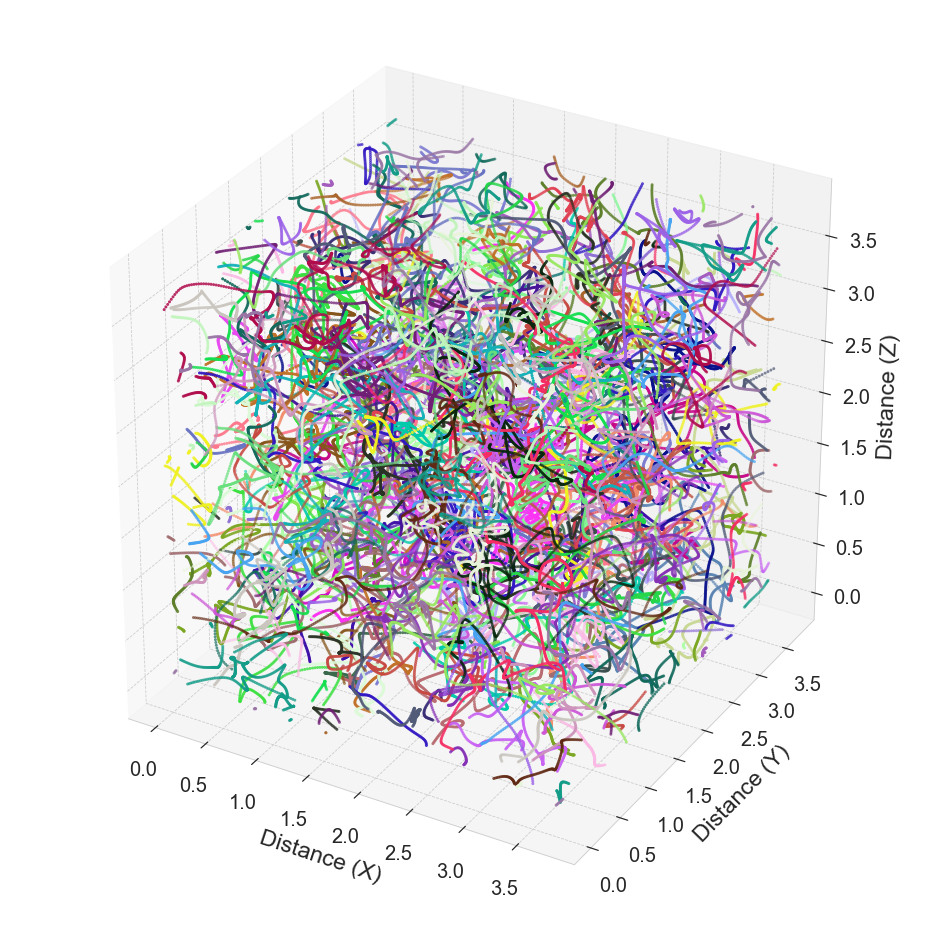

In [19]:
save = True

nrows=1
ncols=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*13,nrows*13),
                         subplot_kw={'projection': '3d'})

axislabelsize = 23
axisticksize = 20
labelpad = 25
tickpad = 15
scattersize = 2

axes.set_xlabel('Distance (X)', fontsize=axislabelsize, labelpad=labelpad)
axes.set_ylabel('Distance (Y)', fontsize=axislabelsize, labelpad=labelpad)
axes.set_zlabel('Distance (Z)', fontsize=axislabelsize, labelpad=labelpad)

axes.tick_params(axis='both', which='major',
                 pad=tickpad, labelsize=axisticksize)

lim_min = None
lim_max = None
steps = 1

start = 0.2
stop = 1.0
cm_subsection = np.linspace(start, stop, N) 
colors = [cm.nipy_spectral(i) for i in cm_subsection]

for n in range(N):
    color = np.array([random.random(), random.random(), random.random()])
    axes.scatter(r_history[lim_min:lim_max:steps,n,0],
                 r_history[lim_min:lim_max:steps,n,1],
                 r_history[lim_min:lim_max:steps,n,2],
                 color=color, s=scattersize**2)

fig.tight_layout()
if save:
    plt.savefig(figsave_dir +
                'trajectories_scatter_{0}.'.format(n_steps) +
                figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
    
    plt.savefig(figsave_dir +
                'trajectories_scatter_{0}.'.format(n_steps) +
                'png',
                format='png',
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

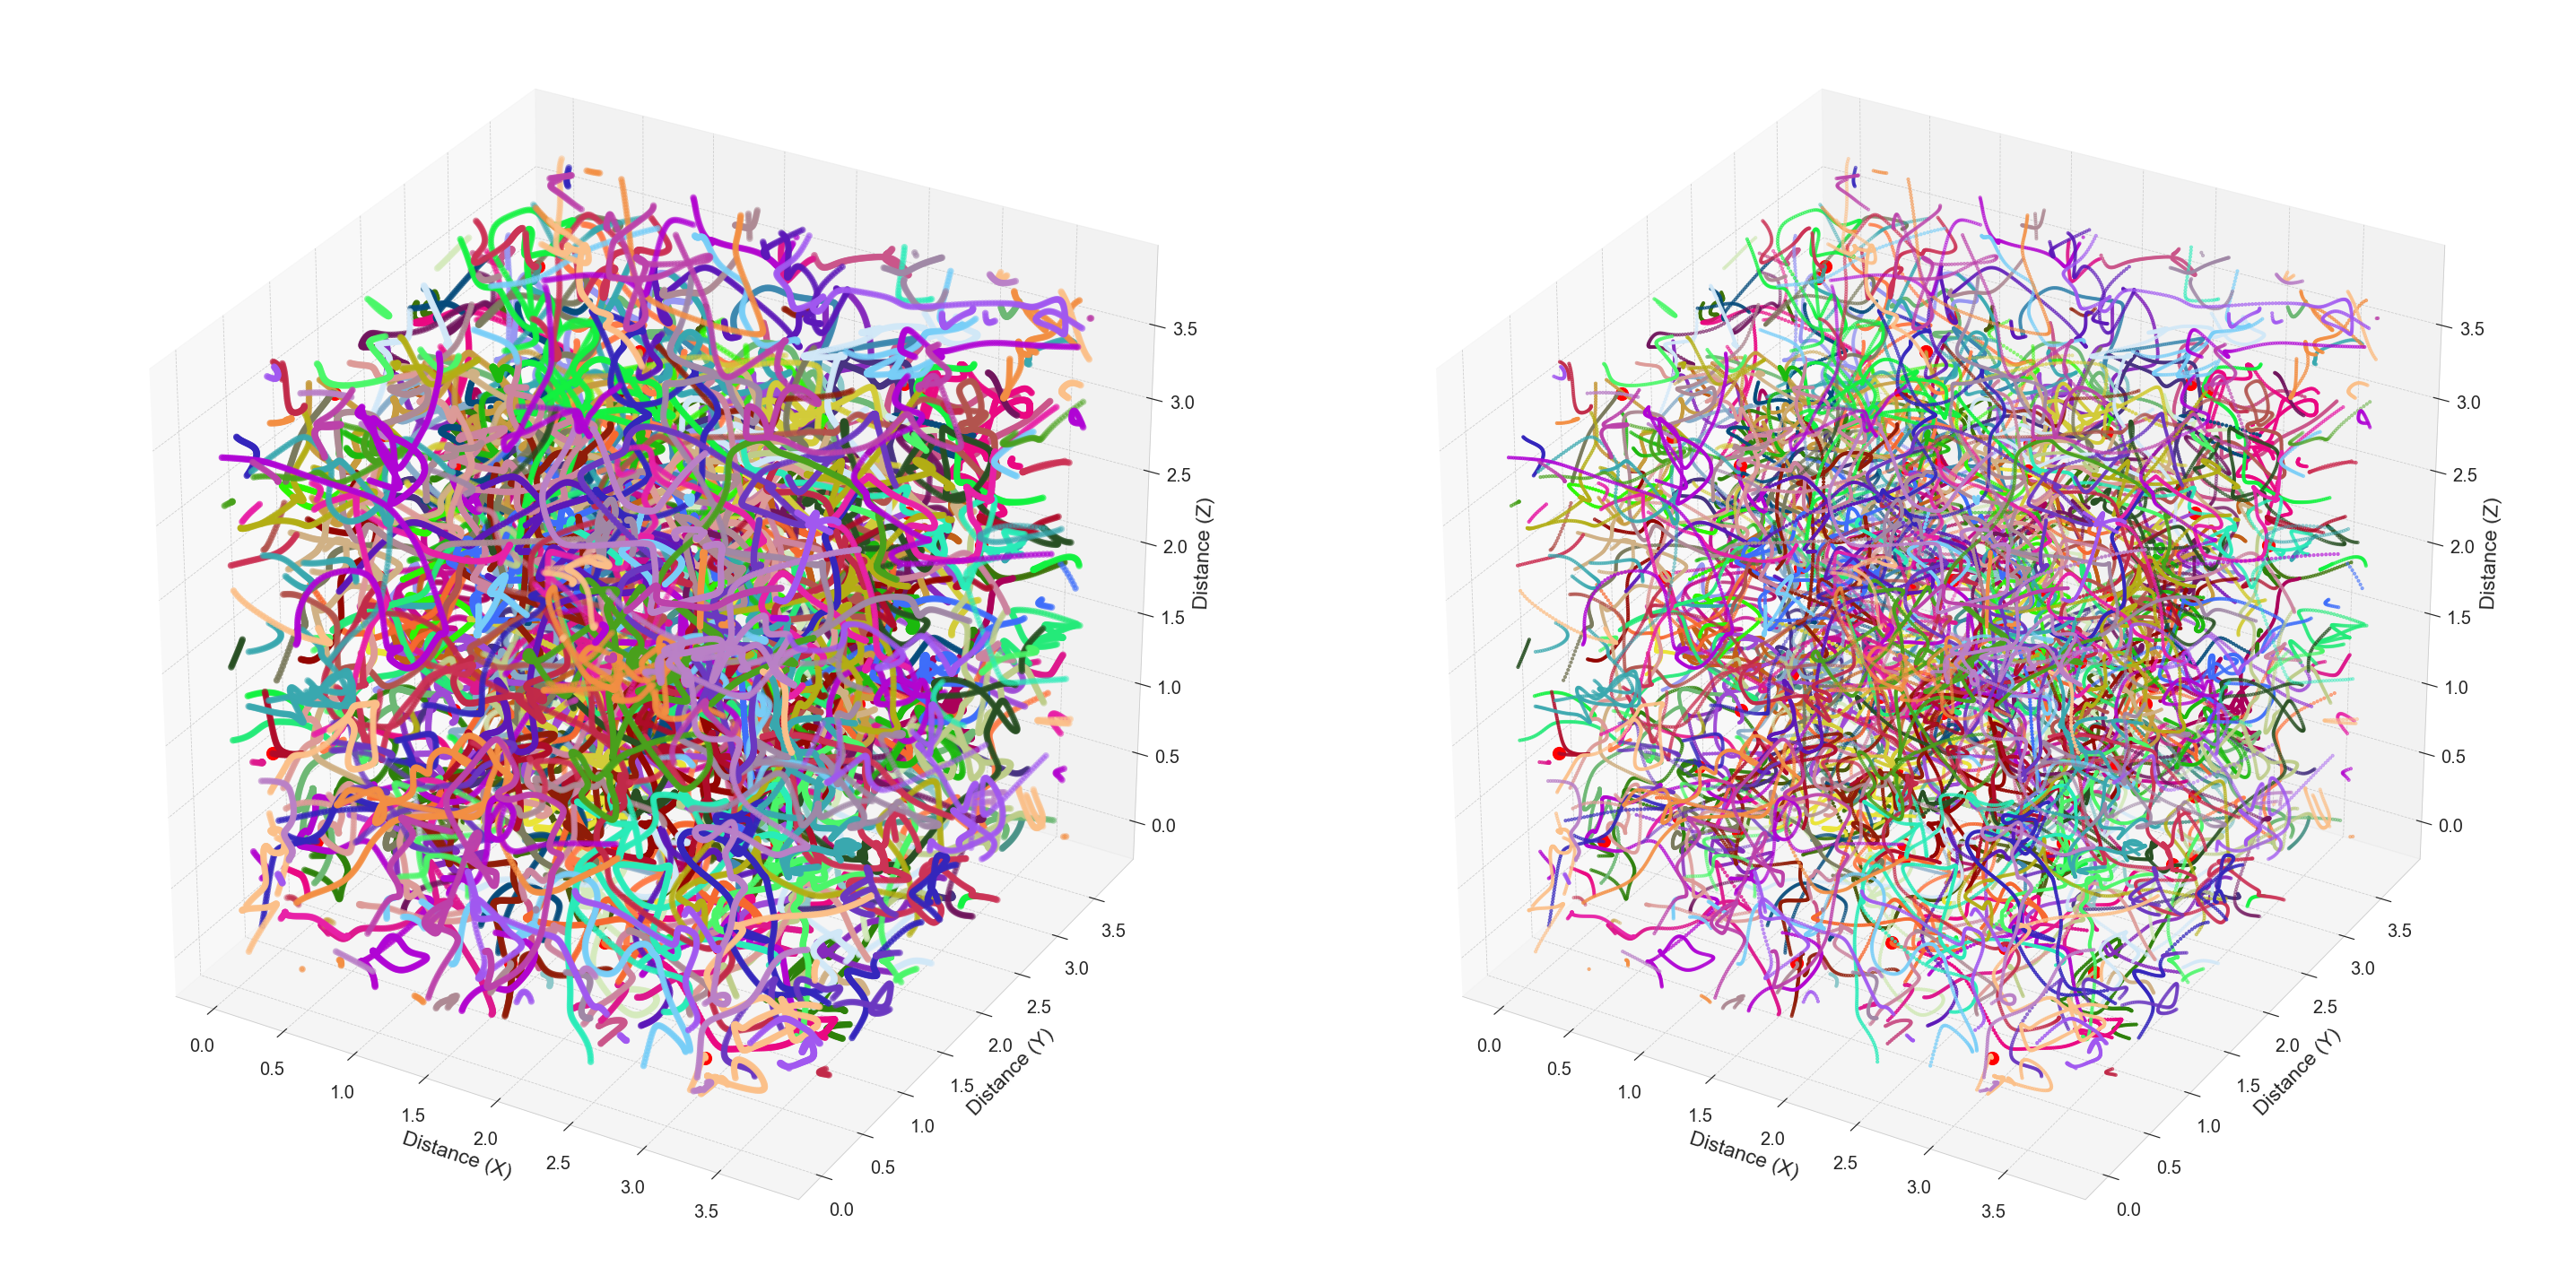

In [40]:
save = True

nrows=1
ncols=3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*20,nrows*20),
                         subplot_kw={'projection': '3d'})

axislabelsize = 23
axisticksize = 20
labelpad = 25
scattersize = 2

lim_min = None
lim_max = None
steps = 1

histories = [r_history, v_history, a_history]
quantities = ['Distance',
              'Velocity',
              'Acceleration']
for n in range(N):
    color = np.array([random.random(), random.random(), random.random()])
    for i in range(ncols):
        axes[i].scatter(histories[i][lim_min:lim_max:steps,n,0],
                        histories[i][lim_min:lim_max:steps,n,1],
                        histories[i][lim_min:lim_max:steps,n,2],
                        color=color, s=10)

for i, qq in enumerate(quantities):
    axes[i].set_xlabel('{0} (X)'.format(qq), fontsize=axislabelsize, labelpad=labelpad)
    axes[i].set_ylabel('{0} (Y)'.format(qq), fontsize=axislabelsize, labelpad=labelpad)
    axes[i].set_zlabel('{0} (Z)'.format(qq), fontsize=axislabelsize, labelpad=labelpad)
    axes[i].tick_params(axis='both', which='major',
                        pad=tickpad, labelsize=axisticksize)

lim_min = None
lim_max = None
steps = 1
for n in range(N):
    color = np.array([random.random(), random.random(), random.random()])
    axes[0].scatter(r_history[lim_min:lim_max:steps,n,0],
                    r_history[lim_min:lim_max:steps,n,1],
                    r_history[lim_min:lim_max:steps,n,2],
                    color=color, lw=3)
    
    axes[0].scatter(r_history[lim_min:lim_max:steps,n,0][-1],
                    r_history[lim_min:lim_max:steps,n,1][-1],
                    r_history[lim_min:lim_max:steps,n,2][-1],
                    color='red', s=200)

    axes[1].scatter(r_history[lim_min:lim_max:steps,n,0],
                    r_history[lim_min:lim_max:steps,n,1],
                    r_history[lim_min:lim_max:steps,n,2],
                    color=color, s=10)

    axes[1].scatter(r_history[lim_min:lim_max:steps,n,0][-1],
                    r_history[lim_min:lim_max:steps,n,1][-1],
                    r_history[lim_min:lim_max:steps,n,2][-1],
                    color='red', s=200)

fig.tight_layout()
if save:
    plt.savefig(figsave_dir +
                'trajectories_compare_{0}.'.format(n_steps) +
                figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
    
    plt.savefig(figsave_dir +
                'trajectories_compare_{0}.'.format(n_steps) +
                'png',
                format='png',
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

## Plotting Lennard-Jones potential

In [3]:
def lennard_jones(X):

    V_0 = 1
    sigma = 1

    return 4 * V_0 * ((sigma/X)**12 - (sigma/X)**6)

In [108]:
X = np.linspace(0.6,5,1000)
Y = lennard_jones(X=X)

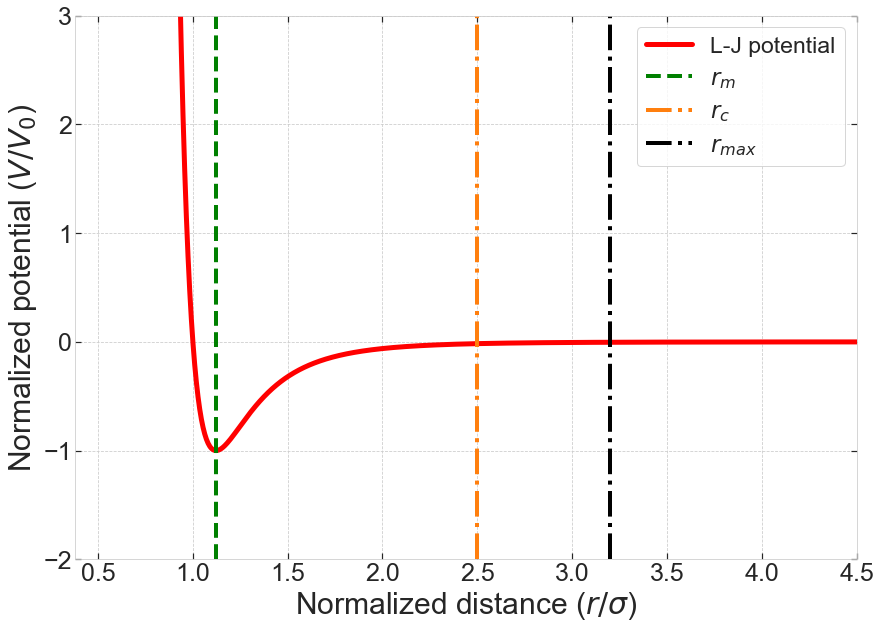

In [5]:
save = False
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,10))

axisticksize = 25
axislabelsize = 30
legendsize = 23

axes.plot(X, Y, color='red', lw=5, label='L-J potential')

axes.set_xlim(left=None, right=4.5)
axes.set_ylim(bottom=-2, top=3)
axes.set_xlabel('Normalized distance ($r/\sigma$)', fontsize=axislabelsize)
axes.set_ylabel('Normalized potential ($V/V_{0}$)', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

axes.axvline(x=2**(1/6), ymin=0, ymax=1, ls='--', lw=4, color='green', label='$r_{m}$')
axes.axvline(x=2.5, ymin=0, ymax=1, ls='-.', lw=4, color='tab:orange', label='$r_{c}$')
axes.axvline(x=3.2, ymin=0, ymax=1, ls='-.', lw=4, color='k', label=r'$r_{max}$')

plt.legend(loc='upper right', fontsize=legendsize)

if save:
    plt.savefig(figsave_dir +
                'Lennard_Jones_Potential.' + figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')

    plt.savefig('..\\Documentation\\Concept\\src\\img_src\\' +
                'Lennard_Jones_Potential.' + figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

In [109]:
def ts_lennard_jones(X, r_c=None):
    
    V_0 = 1
    sigma = 1
    
    Y = np.zeros(len(X))
    
    for i, x in enumerate(X):
        if x < r_c or r_c is None:
            Y[i] = 4 * V_0 * ((sigma/x)**12 - (sigma/x)**6)
        else:
            Y[i] = 0
        
    return Y

In [110]:
X = np.linspace(0.6,5,1000)
Y = ts_lennard_jones(X=X, r_c=2.5)

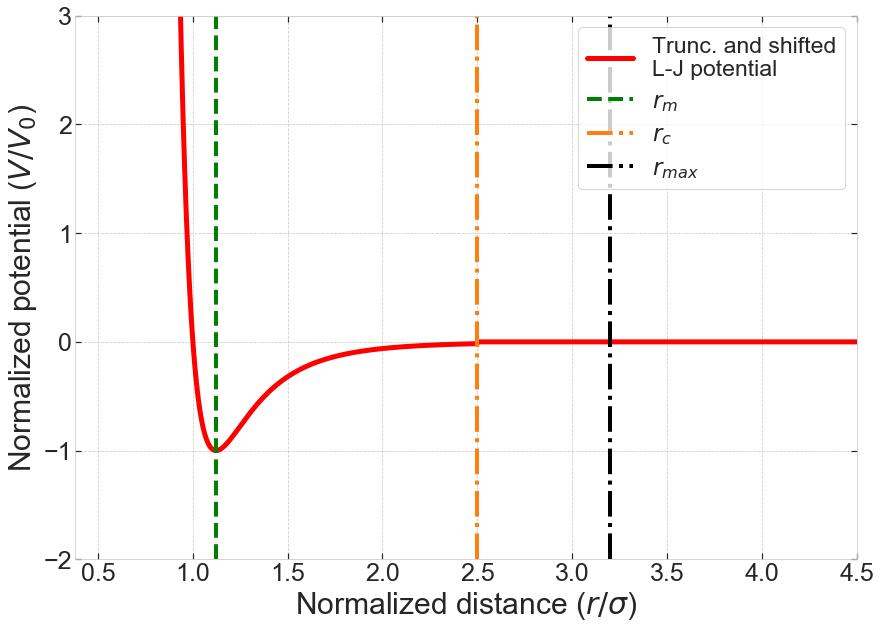

In [112]:
save = True
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,10))

axisticksize = 25
axislabelsize = 30
legendsize = 23

axes.plot(X, Y, color='red', lw=5, label='Trunc. and shifted\nL-J potential')

axes.set_xlim(left=None, right=4.5)
axes.set_ylim(bottom=-2, top=3)
axes.set_xlabel('Normalized distance ($r/\sigma$)', fontsize=axislabelsize)
axes.set_ylabel('Normalized potential ($V/V_{0}$)', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

axes.axvline(x=2**(1/6), ymin=0, ymax=1, ls='--', lw=4, color='green', label='$r_{m}$')
axes.axvline(x=2.5, ymin=0, ymax=1, ls='-.', lw=4, color='tab:orange', label='$r_{c}$')
axes.axvline(x=3.2, ymin=0, ymax=1, ls='-.', lw=4, color='k', label=r'$r_{max}$')

plt.legend(loc='upper right', fontsize=legendsize)

if save:
    plt.savefig(figsave_dir +
                'TS_Lennard_Jones_Potential.' + figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')

    plt.savefig('..\\Documentation\\Concept\\src\\img_src\\' +
                'TS_Lennard_Jones_Potential.' + figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

## gasdev() vs numpy.random.normal()

In [53]:
gasdev_normal = np.array([gasdev() for i in range(1000)])
numpy_normal = np.array([np.random.normal() for i in range(1000)])

C:\Users\Lordpb\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


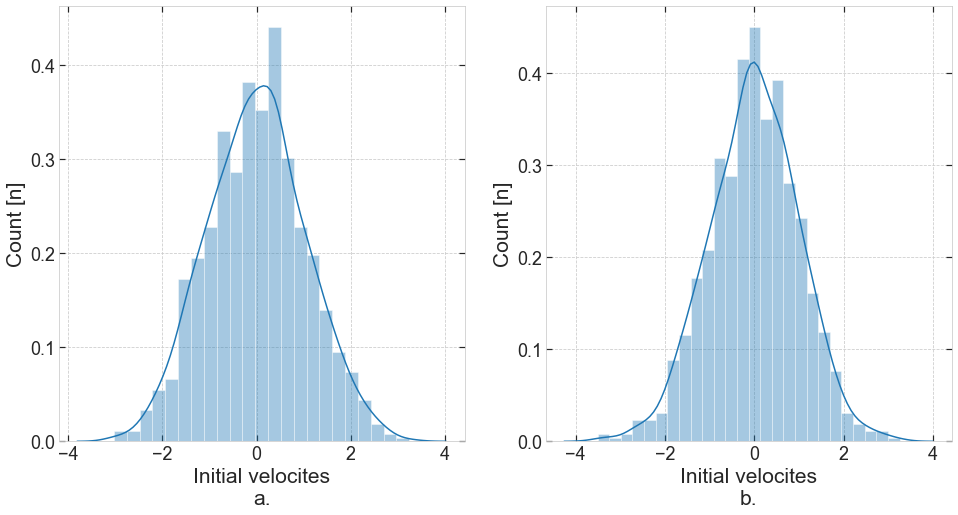

In [54]:
save = True
nrows=1
ncols=2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8,nrows*8))

titlesize = 23
axislabelsize = 21
axisticksize = 18

sns.distplot(gasdev_normal, ax=axes[0])
sns.distplot(numpy_normal, ax=axes[1])

text = ['a', 'b']
for i in range(ncols):
    axes[i].set_xlabel('Initial velocites\n{0}.'.format(text[i]), fontsize=axislabelsize)
    axes[i].set_ylabel('Count [n]', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)

if save:
    plt.savefig(figsave_dir +
                'compare_velocity_distribution.' +
                figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()

#### Transformed velocities

In [55]:
N_test = 800
T_test = 1
gasdev_CM = np.mean(gasdev_normal)
numpy_CM = np.mean(numpy_normal)
# Substract velocity of CM
gasdev_transformed = gasdev_normal - gasdev_CM
numpy_transformed = numpy_normal - numpy_CM
# Rescale with a lamdba constant
gasdev_transformed *= np.sqrt(3 * (N_test-1) * T_test / np.sum(gasdev_transformed**2))
numpy_transformed *= np.sqrt(3 * (N_test-1) * T_test / np.sum(numpy_transformed**2))

C:\Users\Lordpb\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


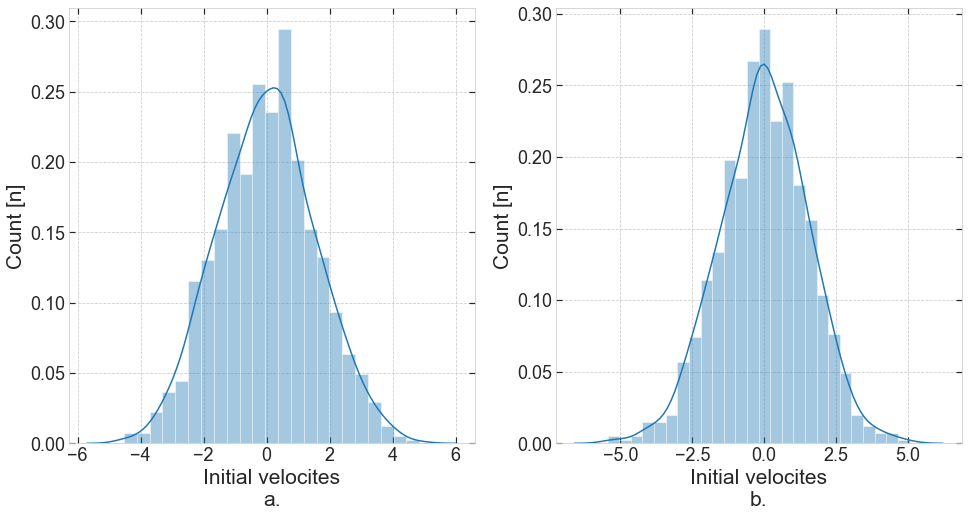

In [56]:
save = True
nrows=1
ncols=2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8,nrows*8))

titlesize = 23
axislabelsize = 21
axisticksize = 18

sns.distplot(gasdev_transformed, ax=axes[0])
sns.distplot(numpy_transformed, ax=axes[1])

text = ['a', 'b']
for i in range(ncols):
    axes[i].set_xlabel('Initial velocites\n{0}.'.format(text[i]), fontsize=axislabelsize)
    axes[i].set_ylabel('Count [n]', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)

if save:
    plt.savefig(figsave_dir +
                'compare_transformed_velocity_distribution.' +
                figsave_format,
                format=figsave_format,
                dpi=figsave_dpi,
                bbox_inches='tight')
plt.show()